## Preprocess

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [3]:
#from uuparser.arc_hybrid import ArcHybridLSTM
#from uuparser import utils
# import stanfordnlp
import stanza
import pickle, os, time
import pandas as pd
import string
from wordcloud import WordCloud, STOPWORDS 
from IPython.display import display, HTML

In [4]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
# tf.config.experimental.set_memory_growth(physical_devices[0], True) #kalau cudablas nya ga mau, run ini sebelum import get_entities

In [9]:
' abc '
'bcsd'

'bcsd'

In [7]:
%cd ..
%pwd

D:\MasterDegree\AMR\amr-amany


'D:\\MasterDegree\\AMR\\amr-amany'

In [8]:
import numpy as np
import pandas as pd
import stanfordnlp
import nltk

import matplotlib.pyplot as plt

from collections import Counter, defaultdict
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from util.ner.entity_recognizer import get_entities

from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from stog.utils.params import Params
from stog.data.dataset_builder import dataset_from_params, iterator_from_params
from stog.data.vocabulary import Vocabulary
from stog.training.trainer import Trainer
#from stog.data.dataset import Batch
#from model.text_to_amr import TextToAMR
from util.amr_parsing.io import AMRIO

[2021-07-07 15:41:23,127 INFO] Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .


TypeError: Couldn't build proto file into descriptor pool!
Invalid proto descriptor for file "tensorboardX/src/resource_handle.proto":
  tensorboard.ResourceHandleProto.device: "tensorboard.ResourceHandleProto.device" is already defined in file "tensorboard/compat/proto/resource_handle.proto".
  tensorboard.ResourceHandleProto.container: "tensorboard.ResourceHandleProto.container" is already defined in file "tensorboard/compat/proto/resource_handle.proto".
  tensorboard.ResourceHandleProto.name: "tensorboard.ResourceHandleProto.name" is already defined in file "tensorboard/compat/proto/resource_handle.proto".
  tensorboard.ResourceHandleProto.hash_code: "tensorboard.ResourceHandleProto.hash_code" is already defined in file "tensorboard/compat/proto/resource_handle.proto".
  tensorboard.ResourceHandleProto.maybe_type_name: "tensorboard.ResourceHandleProto.maybe_type_name" is already defined in file "tensorboard/compat/proto/resource_handle.proto".
  tensorboard.ResourceHandleProto: "tensorboard.ResourceHandleProto" is already defined in file "tensorboard/compat/proto/resource_handle.proto".


In [6]:
my_dir = "C:/Users/Asus/JupyterNotebook/Tesis/amr_parser-master(trainUlang)/data_amany/"

AMR_FILEPATH = my_dir+"data/raw/amr_simple_amany.txt"
AMR_TEST_FILEPATH = my_dir+"data/raw/amr_simple_test.txt"
EDGE_PREDICTION_DATADIR = my_dir+'data/raw/edge_prediction/'

# Dependency feature
DEPENDENCY_FEATURES_FILEPATH = EDGE_PREDICTION_DATADIR + 'dependency_parser_features.csv'
TEST_DEPENDENCY_FEATURES_FILEPATH = EDGE_PREDICTION_DATADIR + 'test_dependency_parser_features.csv'

# Filtered dependency features
FILTERED_DEPENDENCY_FEATURES_FILEPATH = EDGE_PREDICTION_DATADIR + 'dependency_parser_features_filtered.csv'
FILTERED_TEST_DEPENDENCY_FEATURES_FILEPATH = EDGE_PREDICTION_DATADIR + 'test_dependency_parser_features_filtered.csv'

# Labeled
LABELED_TEST_DEPENDENCY_FEATURES_FILEPATH = EDGE_PREDICTION_DATADIR + 'test_dependency_parser_features_labeled.csv'
LABELED_DEPENDENCY_FEATURES_FILEPATH = EDGE_PREDICTION_DATADIR + 'dependency_parser_features_labeled.csv'
LABELED_DEPENDENCY_FEATURES_FILEPATH_NO_UNK = EDGE_PREDICTION_DATADIR + 'dependency_parser_features_labeled_no_unk.csv'

# AMR
AMR_DF_FILEPATH = EDGE_PREDICTION_DATADIR + 'amr.csv'
TEST_AMR_DF_FILEPATH = EDGE_PREDICTION_DATADIR + 'amr.test.csv'

# ANNOTATOR 
ANNOTATOR_PARAMS={
    'pos_tagger': 'nltk'
}

# FILTER TYPE
FILTER_TYPE = ['preposition', 'determiner', 'sc']

# Severina Dataset
TEST_BERITA_DIR = my_dir+"data/raw/test/"
TEST_BERITA_FILE_NAMES = ["b-salah-darat.txt","c-gedung-roboh.txt","d-indo-fuji.txt", "f-bunuh-diri.txt", "g-gempa-dieng.txt"]
TEST_BERITA_FILE_PATHS = [TEST_BERITA_DIR + filename for filename in TEST_BERITA_FILE_NAMES]

## Function Definitions

In [7]:
def show_world_cloud(all_sentence):

    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white',
                    min_font_size = 10).generate(all_sentences) 

    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    
    plt.show() 

In [12]:
class FeatureAnnotator:
    word_dict = {}
    
    def __init__(self, params):
#         self.nlp = stanfordnlp.Pipeline(lang="id",use_gpu=False, silent=True)
        self.nlp = stanza.Pipeline(lang="id",use_gpu=True,verbose=False, tokenize_pretokenized=True)
        factory = StemmerFactory()
        self.stemmer = factory.create_stemmer()
        self.ner = get_entities
        self.params = params
        
        import nltk
        self.pos_tagger = nltk.tag.CRFTagger()
        self.pos_tagger.set_model_file(my_dir+'pretrained/pos_tagger/all_indo_man_tag_corpus_model.crf.tagger')
    def annotate(self, sentence):
        annotation = defaultdict(list)
        sentence = sentence.translate(str.maketrans('', '', string.punctuation))
        doc = self.nlp(sentence)
        
        annotation['ner_tags'] = self.ner(sentence)
        
        word_dict = defaultdict(int)
        
        for sent in doc.sentences:
            for idx, word in enumerate(sent.words):
                annotation['tokens'].append(word.text)
                stemmed_word = self.stemmer.stem(word.text)                
                if (annotation['ner_tags'][idx] in ['PER', 'ORG']):
                    stemmed_word = word.text.lower()
                word_dict[stemmed_word] += 1
                annotation['lemmas'].append(stemmed_word+'_{}'.format(word_dict[stemmed_word]))
                annotation['pos_tags'].append(word.upos)
#                 annotation['dependency'].append(dict(relation=word.dependency_relation, head=word.governor))
                annotation['dependency'].append(dict(relation=word.deprel, head=word.head))
    
        if self.params['pos_tagger'] == 'nltk':
            annotation['pos_tags'] = [tag[1] for tag in self.pos_tagger.tag(annotation['tokens'])]
            
        
        return annotation

# Preprocess

### Features

In [9]:
def dump_amr_features(amr, annotation, f):
    amr.tokens = annotation['tokens']
    amr.lemmas = annotation['lemmas']
    amr.pos_tags = annotation['pos_tags']
    amr.ner_tags = annotation['ner_tags']
    AMRIO.dump([amr], f)

def create_dataset(annotation, sentence_id):
    edge_labels_dataset = {
        'sentence_id': [],
        'parent': [], 
        'parent_position': [], 
        'child': [], 
        'child_position': [], 
        'is_root' : [],
        'sequence': [],
        'parent_ner': [],
        'child_ner': [],
        'parent_pos': [],
        'dependency_role': [],
        'child_pos': []
    }

    for idx, dependency in enumerate(annotation['dependency']):
        head = dependency['head']
        if (head != 0):
            head_idx = head-1
            edge_labels_dataset['sentence_id'].append(sentence_id)
            edge_labels_dataset['sequence'].append(idx+1)
            edge_labels_dataset['parent'].append(annotation['lemmas'][head_idx])
            edge_labels_dataset['parent_position'].append(head_idx)
            edge_labels_dataset['child'].append(annotation['lemmas'][idx])
            edge_labels_dataset['child_position'].append(annotation['lemmas'].index(annotation['lemmas'][idx]))
            edge_labels_dataset['is_root'].append(1 if annotation['dependency'][head_idx]['head'] == 0 else 0)
            edge_labels_dataset['parent_ner'].append(annotation['ner_tags'][head_idx])
            edge_labels_dataset['child_ner'].append(annotation['ner_tags'][idx])
            edge_labels_dataset['parent_pos'].append(annotation['pos_tags'][head_idx])
            edge_labels_dataset['child_pos'].append(annotation['pos_tags'][idx])
            edge_labels_dataset['dependency_role'].append(dependency['relation'])
            
    return edge_labels_dataset

def create_dependency_parser_feature_df(filepath, params):
    sentence_dataset = []
    word_dict = defaultdict(int)
    amrs = []
    sentence_ids = []
    all_sentences = ''
    annotator = FeatureAnnotator(params)
    
    with open(filepath + '.features', 'w', encoding='utf-8') as f:
        for i, amr in enumerate(AMRIO.read(filepath), 1):
            if i % 100 == 0:
                print('{} processed.'.format(i))

            for word in nltk.tokenize.word_tokenize(amr.sentence):
                word_dict[word.lower()] += 1
                all_sentences += word.lower() + ' '
            #print('amr.sentence',amr.sentence)
            annotation = annotator.annotate(amr.sentence)
            dump_amr_features(amr, annotation, f)
            sentence_data = create_dataset(annotation, i)
            sentence_dataset.append(sentence_data)
            sentence_ids.append(i)
            amrs.append(amr)

    dataset_dict = {
        'sentence_id': sum([sum([sentence_data['sentence_id'] for sentence_data in sentence_dataset], [])],[]),
        'sequence': sum([sum([sentence_data['sequence'] for sentence_data in sentence_dataset], [])],[]),
        'parent': sum([sum([sentence_data['parent'] for sentence_data in sentence_dataset], [])],[]),
        'parent_position': sum([sum([sentence_data['parent_position'] for sentence_data in sentence_dataset], [])],[]), 
        'child': sum([sum([sentence_data['child'] for sentence_data in sentence_dataset], [])],[]), 
        'child_position': sum([sum([sentence_data['child_position'] for sentence_data in sentence_dataset], [])],[]), 
        'is_root' : sum([sum([sentence_data['is_root'] for sentence_data in sentence_dataset], [])],[]),
        'parent_ner': sum([sum([sentence_data['parent_ner'] for sentence_data in sentence_dataset], [])],[]),
        'child_ner': sum([sum([sentence_data['child_ner'] for sentence_data in sentence_dataset], [])],[]),
        'parent_pos': sum([sum([sentence_data['parent_pos'] for sentence_data in sentence_dataset], [])],[]),
        'dependency_role': sum([sum([sentence_data['dependency_role'] for sentence_data in sentence_dataset], [])],[]),
        'child_pos': sum([sum([sentence_data['child_pos'] for sentence_data in sentence_dataset], [])],[])
    }

    amr_dict = {
        'sentence_id': sentence_ids,
        'amr': [str(amr.graph) for amr in amrs]
    }

    sentence_dataset = pd.DataFrame(dataset_dict)
    amr_df = pd.DataFrame(amr_dict)
    
    return sentence_dataset, amr_df, all_sentences, amrs

def filter_dataset(data, mode='all'):
    if ('preposition' in mode):
        data = data[data['child_pos'] != 'IN']
    
    if ('determiner' in mode):
        data = data[data['dependency_role'] != 'det']
        
    if ('case' in mode):
        data = data[data['dependency_role'] != 'case']
    
    if ('sc' in mode):
        data = data[data['child_pos'] != 'SC']
    
    return data

### Pair Label Generation

In [10]:
def create_pair_labels(train_data):
    pairs = []
    for sentence_id, data in enumerate(train_data):
        tokens =  data.fields['tgt_tokens'].tokens[1:-1]
        head_indices = data.fields['head_indices'].labels
        labels = data.fields['head_tags'].labels
        
        for i, index in enumerate(head_indices):
            if (index != 0):
                parent = tokens[index-1]
                child = tokens[i]
                label = labels[i]
                pairs.append((sentence_id+1, str(parent), str(child),str(label)))
                
    return pairs

def find_label(data, pair_labels):
    for pair_label in pair_labels:
        sentence_id, label_parent, label_child, label = pair_label
        if (data['sentence_id'] == sentence_id and data['parent'] == label_parent and data['child']==label_child):
            return label
    return "unk"
    
def create_labels(pair_labels, sentence_dataset, change_unk_to_mod=False, with_flipped=False):
    found_or_not = []
    labels = []
    unk_pairs = []
    pair_labels_dict = dict()
    not_found_count = 0
    found_count = 0
    
    for idx, data in sentence_dataset.iterrows():
        found = False
        flipped_found = False
        flipped_data = None
        
        if (data['sentence_id'] not in pair_labels_dict):
            #ditambah None untuk menampung label hasil prediksi nantinya (Kalau sampai akhir tetap None, artinya : pair tidak dilabeli)
            pair_labels_dict[data['sentence_id']] = [pair_label + (None,) for pair_label in pair_labels if pair_label[0] == data['sentence_id']]   
        cur_pair_labels = pair_labels_dict[data['sentence_id']]
            
        for i, pair_label in enumerate(pair_labels_dict[data['sentence_id']]):
            _, label_parent, label_child, label, ketemu = pair_label
            if (data['parent'].split('_')[0] == label_parent and data['child'].split('_')[0]==label_child):
                labels.append(label)
                found = True
                pair_labels_dict[data['sentence_id']][i] = _, label_parent, label_child, label, label
                break

            elif with_flipped and (data['parent'].split('_')[0] == label_child and data['child'].split('_')[0]==label_parent):
                flipped_found = True
                print('ADA FLIPPED')
                flipped_data = (data['child'], data['parent'], label)
#             found_or_not.append(found)
        
        if flipped_found and not found:
            sentence_dataset.loc[idx,'parent'] = flipped_data[0]
            sentence_dataset.loc[idx,'child'] = flipped_data[1]
            labels.append(flipped_data[2])
        
        if not flipped_found and not found:
            not_found_count += 1
            dependency_role = data['dependency_role'] 
            if (dependency_role in ['nsubj']):
                labels.append("ARG0")
#                pair_labels_dict[data['sentence_id']][i] = _, label_parent, label_child, label, 'ARG0'
            elif (dependency_role in ['obl', 'obj']):
                labels.append('ARG1')
#                pair_labels_dict[data['sentence_id']][i] = _, label_parent, label_child, label, 'ARG1'
            elif (dependency_role in ['case'] and data['child'] in ['di', 'ke', 'dari']):
                labels.append('location')
 #               pair_labels_dict[data['sentence_id']][i] = _, label_parent, label_child, label, 'location'
            else:
                if change_unk_to_mod:
                    labels.append("mod")
  #                  pair_labels_dict[data['sentence_id']][i] = _, label_parent, label_child, label, "mod"
                else: 
                    labels.append("unk")
   #                 pair_labels_dict[data['sentence_id']][i] = _, label_parent, label_child, label, "unk"

            unk_pairs.append((data['parent'], data['child'], dependency_role, data['sentence_id']))
            found_or_not.append(False)
        else:
            found_count += 1
            found_or_not.append(True)   
    
    print("Found pairs: ", found_count)
    print("AMR Pair labels: ", len(pair_labels))
    print("Dependency Parser Pair labels: ", len(sentence_dataset))
    print("Not found: ", not_found_count)
    
    precision = found_count/len(sentence_dataset)
    recall = found_count/len(pair_labels)
    print("Pair Precision: ", precision)
    print("Pair Recall: ", recall)
    print("Pair F1: ", 2*((precision*recall)/(precision+recall)))
    
    return labels, unk_pairs, found_or_not, pair_labels_dict

In [14]:
labels_no_unk, unk_pairs, found_or_not, pair_labels_dict = create_labels(pair_labels[:],filtered_sentence_dataset[:], change_unk_to_mod=True)

Found pairs:  4969
AMR Pair labels:  7555
Dependency Parser Pair labels:  7395
Not found:  2426
Pair Precision:  0.6719405003380663
Pair Recall:  0.65771012574454
Pair F1:  0.6647491638795987


In [15]:
actual = []
pred = []
kelas = []
for i,j in enumerate(pair_labels_dict):
    for a,b in enumerate(pair_labels_dict[j]):
        _, label_parent, label_child, label_actual, label_prediction = b
        actual.append(str(label_actual))
        pred.append(str(label_prediction))
        if str(label_prediction) not in kelas:
            kelas.append(str(label_prediction))

In [16]:
kelas= ['ARG0','ARG1','location','mod','name', 'time','None']

In [51]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(actual, pred, kelas)
cm

array([[1362,    0,    0,    0,    0,    0,  615],
       [   0, 1220,    0,    0,    0,    0,  448],
       [   0,    0,  432,    0,    0,    0,  220],
       [   0,    0,    0, 1047,    0,    0,  885],
       [   0,    0,    0,    0,  597,    0,   85],
       [   0,    0,    0,    0,    0,  303,  336],
       [   0,    0,    0,    0,    0,    0,    0]], dtype=int64)

In [92]:
jml_label = {}
rasio_not_found = {}
for i,j in enumerate(cm):
    betul = j[i]
    jadi_none = j[len(j)-1]
    rasio_jadi_none = jadi_none/(betul+jadi_none)
    if np.isnan(rasio_jadi_none):
        rasio_jadi_none = 0
    print(kelas[i],'==>',round(rasio_jadi_none,2))
    rasio_not_found[kelas[i]] = round(rasio_jadi_none,2)
    jml_label[kelas[i]] = betul+jadi_none
print(rasio_not_found)
print(jml_label)

ARG0 ==> 0.31
ARG1 ==> 0.27
location ==> 0.34
mod ==> 0.46
name ==> 0.12
time ==> 0.53
None ==> 0
{'ARG0': 0.31, 'ARG1': 0.27, 'location': 0.34, 'mod': 0.46, 'name': 0.12, 'time': 0.53, 'None': 0}
{'ARG0': 1977, 'ARG1': 1668, 'location': 652, 'mod': 1932, 'name': 682, 'time': 639, 'None': 0}


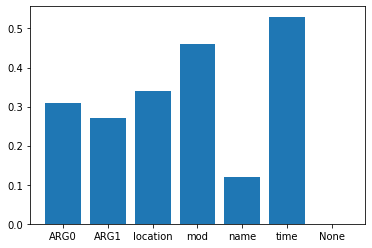

In [131]:
import matplotlib.pyplot as plt

D = rasio_not_found

plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()))

plt.show()

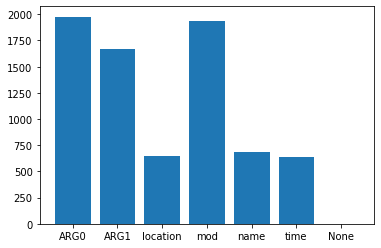

In [132]:
import matplotlib.pyplot as plt

D = jml_label

plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()))

plt.show()

In [133]:
jml_label_adylan = {'ARG0': 665, 'ARG1': 565, 'location': 189, 'mod': 550, 'name': 242, 'time': 158, 'None': 0}
jml_label_amany = jml_label
rasio_not_found_adylan = {'ARG0': 0.21, 'ARG1': 0.17, 'location': 0.28, 'mod': 0.43, 'name': 0.12, 'time': 0.55, 'None': 0}
rasio_not_found_amany = rasio_not_found
hasil = []
for i in jml_label_amany:
    selisih = (jml_label_amany[i]-jml_label_adylan[i])
    rasio = 0
    if jml_label_adylan[i]!= 0:
        rasio = round(jml_label_amany[i]/jml_label_adylan[i],2)
    
    selisih2 = round(abs(rasio_not_found_amany[i]-rasio_not_found_adylan[i]),2)
    rasio2 = 0
    if rasio_not_found_adylan[i]!= 0:
        rasio2 = round(rasio_not_found_amany[i]/rasio_not_found_adylan[i],2)
    hasil.append([i,selisih,rasio,selisih2,rasio2])
    print(i,selisih,rasio,selisih2,rasio2)

ARG0 1312 2.97 0.1 1.48
ARG1 1103 2.95 0.1 1.59
location 463 3.45 0.06 1.21
mod 1382 3.51 0.03 1.07
name 440 2.82 0.0 1.0
time 481 4.04 0.02 0.96
None 0 0 0 0


In [134]:
dict(sorted(hasil.items(), key=lambda item: item[1]))

AttributeError: 'list' object has no attribute 'items'

In [121]:
dict(sorted(jml_label_adylan.items(), key=lambda item: item[1]))

{'None': 0,
 'time': 158,
 'location': 189,
 'name': 242,
 'mod': 550,
 'ARG1': 565,
 'ARG0': 665}

In [122]:
dict(sorted(jml_label_amany.items(), key=lambda item: item[1]))

{'None': 0,
 'time': 639,
 'location': 652,
 'name': 682,
 'ARG1': 1668,
 'mod': 1932,
 'ARG0': 1977}

In [123]:
dict(sorted(rasio_not_found_adylan.items(), key=lambda item: item[1]))

{'None': 0,
 'name': 0.12,
 'ARG1': 0.17,
 'ARG0': 0.21,
 'location': 0.28,
 'mod': 0.43,
 'time': 0.55}

In [124]:
dict(sorted(rasio_not_found_amany.items(), key=lambda item: item[1]))

{'None': 0,
 'name': 0.12,
 'ARG1': 0.27,
 'ARG0': 0.31,
 'location': 0.34,
 'mod': 0.46,
 'time': 0.53}

In [137]:
from operator import itemgetter
sorted(hasil, key=itemgetter(1)) #diurutkan berdasarkan kenaikan jumlah label

[['None', 0, 0, 0, 0],
 ['name', 440, 2.82, 0.0, 1.0],
 ['location', 463, 3.45, 0.06, 1.21],
 ['time', 481, 4.04, 0.02, 0.96],
 ['ARG1', 1103, 2.95, 0.1, 1.59],
 ['ARG0', 1312, 2.97, 0.1, 1.48],
 ['mod', 1382, 3.51, 0.03, 1.07]]

In [52]:
pred.count('None')/len(pred)

0.34334877564526806

[[1362    0    0    0    0    0  615]
 [   0 1220    0    0    0    0  448]
 [   0    0  432    0    0    0  220]
 [   0    0    0 1047    0    0  885]
 [   0    0    0    0  597    0   85]
 [   0    0    0    0    0  303  336]
 [   0    0    0    0    0    0    0]]


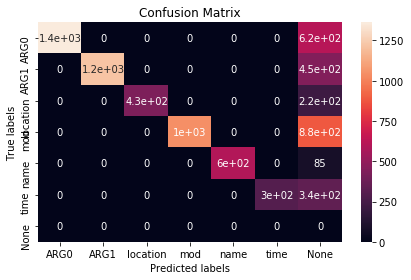

In [55]:
print(cm)
import seaborn as sns
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(kelas); ax.yaxis.set_ticklabels(kelas);
ax.set_ylim(sorted(ax.get_xlim(), reverse=True)) #supaya confusion matrix nya tidak ke crop
plt.tight_layout()
plt.show()

In [42]:
TP = 4969

#FP (False Positive ==> Actual Class adalah Negative)
#Pair hasil prediksi yang seharusnya tidak ditemukan (harusnya :tidak ditemukan, tapi hasil prediksi :ada (found))
FP = len(filtered_sentence_dataset) - TP

#FN (False Negative ==> Actual Class adalah Positive)
#Pair Gold yang seharusnya ditemukan (harusnya :ada (found), tapi hasil prediksi :tidak ditemukan)
FN = len(pair_labels) - TP 

precision = TP/(TP+FP)
recall = TP/(TP+FN)

print("Pair Precision: ", precision)
print("Pair Recall: ", recall)
print("Pair F1: ", 2*((precision*recall)/(precision+recall)))

Pair Precision:  0.6719405003380663
Pair Recall:  0.65771012574454
Pair F1:  0.6647491638795987


In [43]:
#Barusan : Sudah run semua (yang found di beri label. yang not found diberi None)
#TO DO : Hitung berapa yang NONE di pair_labels_dict
hitung = 0
for i,j in enumerate(pair_labels_dict):
    #print(i,pair_labels_dict[j])
    for a,b in enumerate(pair_labels_dict[j]):
        #print(a,b)
        _, label_parent, label_child, label_asli, label_pred = b
        #print(label_asli,label_pred)
        if label_pred == None:
            hitung+=1
print(hitung) #pair_labels (gold AMR) yang gak ada di hasil prediksi

2594


In [44]:
pair_labels_dict

{1: [(1, 'tanam', 'bu', 'ARG0', 'ARG0'),
  (1, 'bu', 'ani', 'name', 'name'),
  (1, 'tanam', 'bunga', 'ARG1', 'ARG1')],
 2: [(2, 'tanam', 'bu', 'ARG0', 'ARG0'),
  (2, 'bu', 'ani', 'name', None),
  (2, 'tanam', 'bunga', 'ARG1', 'ARG1')],
 3: [(3, 'berangkat', 'om', 'ARG0', 'ARG0'),
  (3, 'om', 'andi', 'name', 'name'),
  (3, 'berangkat', 'sekolah', 'ARG1', 'ARG1'),
  (3, 'sekolah', 'ke', 'mod', None),
  (3, 'berangkat', 'besok', 'time', 'time')],
 4: [(4, 'berangkat', 'om', 'ARG0', 'ARG0'),
  (4, 'om', 'andi', 'name', 'name'),
  (4, 'berangkat', 'sekolah', 'ARG1', 'ARG1'),
  (4, 'sekolah', 'ke', 'mod', None),
  (4, 'berangkat', 'besok', 'time', 'time')],
 5: [(5, 'pergi', 'ibu', 'ARG0', 'ARG0'),
  (5, 'ibu', 'asih', 'name', 'name'),
  (5, 'pergi', 'rumah', 'location', 'location'),
  (5, 'rumah', 'nenek', 'mod', 'mod'),
  (5, 'nenek', 'yanti', 'name', 'name'),
  (5, 'pergi', 'kemarin', 'time', 'time')],
 6: [(6, 'pergi', 'ibu', 'ARG0', None),
  (6, 'ibu', 'asih', 'name', 'name'),
  (6, 'pe

In [20]:
# def create_labels(pair_labels, sentence_dataset, change_unk_to_mod=False, with_flipped=False):
#     found_or_not = []
#     labels = []
#     unk_pairs = []
#     pair_labels_dict = dict()
#     not_found_count = 0
#     found_count = 0
    
#     for idx, data in sentence_dataset.iterrows():
#         found = False
#         flipped_found = False
#         flipped_data = None
        
#         if (data['sentence_id'] not in pair_labels_dict):
#             pair_labels_dict[data['sentence_id']] = [pair_label for pair_label in pair_labels if pair_label[0] == data['sentence_id']]    
#         cur_pair_labels = pair_labels_dict[data['sentence_id']]
            
#         for pair_label in cur_pair_labels:
#             _, label_parent, label_child, label = pair_label
#             if (data['parent'].split('_')[0] == label_parent and data['child'].split('_')[0]==label_child):
#                 labels.append(label)
#                 found = True
#                 break

#             elif with_flipped and (data['parent'].split('_')[0] == label_child and data['child'].split('_')[0]==label_parent):
#                 flipped_found = True
#                 flipped_data = (data['child'], data['parent'], label)
# #             found_or_not.append(found)
        
#         if flipped_found and not found:
#             sentence_dataset.loc[idx,'parent'] = flipped_data[0]
#             sentence_dataset.loc[idx,'child'] = flipped_data[1]
#             labels.append(flipped_data[2])
        
#         if not flipped_found and not found:
#             not_found_count += 1
#             dependency_role = data['dependency_role'] 
#             if (dependency_role in ['nsubj']):
#                 labels.append("ARG0")
#             elif (dependency_role in ['obl', 'obj']):
#                 labels.append('ARG1')
#             elif (dependency_role in ['case'] and data['child'] in ['di', 'ke', 'dari']):
#                 labels.append('location')
#             else:
#                 if change_unk_to_mod:
#                     labels.append("mod")
#                 else: 
#                     labels.append("unk")

#             unk_pairs.append((data['parent'], data['child'], dependency_role, data['sentence_id']))
#             found_or_not.append(False)
#         else:
#             found_count += 1
#             found_or_not.append(True)   
    
#     print("Found pairs: ", found_count)
#     print("AMR Pair labels: ", len(pair_labels))
#     print("Dependency Parser Pair labels: ", len(sentence_dataset))
#     print("Not found: ", not_found_count)
    
#     precision = found_count/len(sentence_dataset)
#     recall = found_count/len(pair_labels)
#     print("Pair Precision: ", precision)
#     print("Pair Recall: ", recall)
#     print("Pair F1: ", 2*((precision*recall)/(precision+recall)))
    
#     return labels, unk_pairs, found_or_not

#### Dev data

In [14]:
sentence_dataset, amr_df, all_sentences, amrs = create_dependency_parser_feature_df(AMR_FILEPATH, ANNOTATOR_PARAMS)
test_sentence_dataset, test_amr_df, test_all_sentences, test_amrs = create_dependency_parser_feature_df(AMR_TEST_FILEPATH, ANNOTATOR_PARAMS)

100 processed.
200 processed.
300 processed.
400 processed.
500 processed.
600 processed.
700 processed.
800 processed.
900 processed.
1000 processed.
1100 processed.
1200 processed.
1300 processed.
1400 processed.
1500 processed.
1600 processed.
1700 processed.
1800 processed.
1900 processed.
2000 processed.
2100 processed.
100 processed.
200 processed.
300 processed.


### [Checkpoint 1 ] Save Dependency Features & AMR

In [15]:
sentence_dataset.to_csv(DEPENDENCY_FEATURES_FILEPATH, index=None)
test_sentence_dataset.to_csv(TEST_DEPENDENCY_FEATURES_FILEPATH, index=None)
amr_df.to_csv(AMR_DF_FILEPATH, index=None)
test_amr_df.to_csv(TEST_AMR_DF_FILEPATH, index=None)

### Load Dependency Features

In [16]:
sentence_dataset = pd.read_csv(DEPENDENCY_FEATURES_FILEPATH)
test_sentence_dataset = pd.read_csv(TEST_DEPENDENCY_FEATURES_FILEPATH)

## Filtering

In [17]:
# FILTER_TYPE = []
filtered_sentence_dataset = filter_dataset(sentence_dataset, mode=FILTER_TYPE)
filtered_test_sentence_dataset = filter_dataset(test_sentence_dataset, mode=FILTER_TYPE)

### Save Filtered Dependency Features Data

In [18]:
# Do Filter
filtered_sentence_dataset.to_csv(FILTERED_DEPENDENCY_FEATURES_FILEPATH, index=None)
filtered_test_sentence_dataset.to_csv(FILTERED_TEST_DEPENDENCY_FEATURES_FILEPATH, index=None)

### [Checkpoint 2] Load Filtered Dependency Parser Features dataset

In [19]:
filtered_sentence_dataset = pd.read_csv(FILTERED_DEPENDENCY_FEATURES_FILEPATH)
filtered_test_sentence_dataset = pd.read_csv(FILTERED_TEST_DEPENDENCY_FEATURES_FILEPATH)

## Create Label Features

In [20]:
data_params = dict(
    data_dir=my_dir+"data/raw",
    train_data="amr_simple_amany.txt.features",
    test_data="amr_simple_test.txt.features",
    dev_data="amr_simple_amany.txt.features",
    data_type="AMR"
)

amr_dataset = dataset_from_params(data_params)
amr_data = amr_dataset['train']

0it [00:00, ?it/s][2021-05-10 10:33:40,704 INFO] Reading instances from lines in file at: C:/Users/Asus/JupyterNotebook/Tesis/amr_parser-master(trainUlang)/data_amany/data/raw\amr_simple_amany.txt.features
117it [00:00, 1115.29it/s]

Building train datasets ...
False


2124it [00:01, 1128.58it/s]
0it [00:00, ?it/s][2021-05-10 10:33:42,591 INFO] Reading instances from lines in file at: C:/Users/Asus/JupyterNotebook/Tesis/amr_parser-master(trainUlang)/data_amany/data/raw\amr_simple_amany.txt.features
194it [00:00, 1693.79it/s]

Building dev datasets ...
False


2124it [00:01, 1232.73it/s]
0it [00:00, ?it/s][2021-05-10 10:33:44,314 INFO] Reading instances from lines in file at: C:/Users/Asus/JupyterNotebook/Tesis/amr_parser-master(trainUlang)/data_amany/data/raw\amr_simple_test.txt.features
117it [00:00, 1157.22it/s]

Building test datasets ...
False


306it [00:00, 1197.20it/s]


#### Create Pair Labels

In [21]:
pair_labels = create_pair_labels(amr_data)
labels_no_unk, unk_pairs, found_or_not,_ = create_labels(pair_labels,filtered_sentence_dataset, change_unk_to_mod=True)
dependency_features_dict = filtered_sentence_dataset.to_dict()
dependency_features_dict['label'] = pd.Series(labels_no_unk)
dependency_features_df = pd.DataFrame(dependency_features_dict)
dependency_features_df.to_csv(LABELED_DEPENDENCY_FEATURES_FILEPATH_NO_UNK, index=None)

Found pairs:  4926
AMR Pair labels:  7555
Dependency Parser Pair labels:  7356
Not found:  2430
Pair Precision:  0.6696574225122349
Pair Recall:  0.6520185307743216
Pair F1:  0.6607202736234994


In [22]:
pair_labels

[(1, 'tanam', 'bu', 'ARG0'),
 (1, 'bu', 'ani', 'name'),
 (1, 'tanam', 'bunga', 'ARG1'),
 (2, 'tanam', 'bu', 'ARG0'),
 (2, 'bu', 'ani', 'name'),
 (2, 'tanam', 'bunga', 'ARG1'),
 (3, 'berangkat', 'om', 'ARG0'),
 (3, 'om', 'andi', 'name'),
 (3, 'berangkat', 'sekolah', 'ARG1'),
 (3, 'sekolah', 'ke', 'mod'),
 (3, 'berangkat', 'besok', 'time'),
 (4, 'berangkat', 'om', 'ARG0'),
 (4, 'om', 'andi', 'name'),
 (4, 'berangkat', 'sekolah', 'ARG1'),
 (4, 'sekolah', 'ke', 'mod'),
 (4, 'berangkat', 'besok', 'time'),
 (5, 'pergi', 'ibu', 'ARG0'),
 (5, 'ibu', 'asih', 'name'),
 (5, 'pergi', 'rumah', 'location'),
 (5, 'rumah', 'nenek', 'mod'),
 (5, 'nenek', 'yanti', 'name'),
 (5, 'pergi', 'kemarin', 'time'),
 (6, 'pergi', 'ibu', 'ARG0'),
 (6, 'ibu', 'asih', 'name'),
 (6, 'pergi', 'rumah', 'location'),
 (6, 'rumah', 'nenek', 'mod'),
 (6, 'nenek', 'yanti', 'name'),
 (6, 'pergi', 'kemarin', 'time'),
 (7, 'pergi', 'kami', 'ARG0'),
 (7, 'kami', 'keluarga', 'mod'),
 (7, 'pergi', 'tamasya', 'ARG1'),
 (7, 'pergi'

In [23]:
filtered_sentence_dataset

,sentence_id,sequence,parent,parent_position,child,child_position,is_root,parent_ner,child_ner,parent_pos,dependency_role,child_pos
0,1,1,tanam_1,2,bu_1,0,1,O,ORG,VB,nsubj,NNP
1,1,2,bu_1,0,ani_1,1,0,ORG,PER,NNP,flat,NNP
2,1,4,tanam_1,2,bunga_1,3,1,O,O,VB,obj,NN
3,2,1,tanam_1,1,bunga_1,0,1,O,O,VB,nsubj:pass,NN
4,2,3,tanam_1,1,bu_1,2,1,O,O,VB,obj,NNP
...,...,...,...,...,...,...,...,...,...,...,...,...
7351,2123,6,laku_1,2,hari_1,5,1,O,O,VB,obl,NN
7352,2124,2,laku_1,5,hari_1,1,1,O,O,VB,obl,NN
7353,2124,4,laku_1,5,upacara_1,3,1,O,O,VB,nsubj:pass,NN
7354,2124,5,upacara_1,3,bendera_1,4,0,O,O,NN,compound,NN


In [24]:
label_found = []
for i,j in enumerate(labels_no_unk):
    temp = []
    temp.append(labels_no_unk[i])
    temp.append(found_or_not[i])
    label_found.append(temp)

In [25]:
labels_no_unk

['ARG0',
 'name',
 'ARG1',
 'ARG1',
 'ARG0',
 'name',
 'ARG0',
 'name',
 'ARG1',
 'time',
 'time',
 'ARG0',
 'name',
 'ARG1',
 'ARG0',
 'name',
 'location',
 'mod',
 'name',
 'time',
 'time',
 'mod',
 'name',
 'location',
 'mod',
 'name',
 'ARG0',
 'mod',
 'ARG1',
 'ARG1',
 'mod',
 'ARG0',
 'mod',
 'ARG1',
 'mod',
 'mod',
 'ARG0',
 'mod',
 'ARG1',
 'time',
 'mod',
 'time',
 'mod',
 'ARG0',
 'mod',
 'ARG1',
 'time',
 'mod',
 'ARG0',
 'mod',
 'ARG1',
 'ARG0',
 'location',
 'mod',
 'mod',
 'mod',
 'mod',
 'mod',
 'mod',
 'ARG0',
 'ARG0',
 'ARG0',
 'ARG1',
 'ARG1',
 'ARG0',
 'name',
 'ARG0',
 'ARG1',
 'ARG1',
 'ARG1',
 'mod',
 'ARG0',
 'location',
 'mod',
 'mod',
 'ARG0',
 'mod',
 'location',
 'ARG0',
 'name',
 'ARG1',
 'location',
 'ARG1',
 'ARG1',
 'mod',
 'location',
 'location',
 'mod',
 'ARG1',
 'mod',
 'location',
 'ARG0',
 'mod',
 'ARG1',
 'location',
 'ARG0',
 'name',
 'ARG1',
 'ARG0',
 'ARG1',
 'ARG1',
 'mod',
 'ARG0',
 'mod',
 'mod',
 'mod',
 'mod',
 'mod',
 'ARG1',
 'ARG0',
 'AR

In [27]:
display(dependency_features_df['label'].value_counts())

mod         2917
ARG1        1625
ARG0        1519
name         599
location     432
time         303
Name: label, dtype: int64

In [28]:
dependency_features_df.tail()

,sentence_id,sequence,parent,parent_position,child,child_position,is_root,parent_ner,child_ner,parent_pos,dependency_role,child_pos,label
7390,2123,6,laku_1,2,hari_1,5,1,O,O,VB,obl,NN,time
7391,2124,2,laku_1,5,hari_1,1,1,O,O,VB,obl,NN,time
7392,2124,4,laku_1,5,upacara_1,3,1,O,O,VB,nsubj:pass,NN,ARG1
7393,2124,5,upacara_1,3,bendera_1,4,0,O,O,NN,compound,NN,mod
7394,2124,8,laku_1,5,murid_1,7,1,O,O,VB,obl,FW,ARG0


### Analyze undetected pairs

In [26]:
start_idx = 350
for unk_pair in unk_pairs[start_idx:start_idx+50]:
    print(amrs[unk_pair[-1]-1].sentence)
    print("Label salah: ", unk_pair)
    print("Hasil Dependency Parser: ")
    display(dependency_features_df[dependency_features_df.sentence_id == unk_pair[-1]])
    
    print("Gold AMR:")
    print(amrs[unk_pair[-1]-1].graph)
    print()
    print('----------------------------------------------------------------------------------------------------------------')    

Roti itu busuk
Label salah:  ('roti_1', 'busuk_1', 'amod', 343)
Hasil Dependency Parser: 


,sentence_id,sequence,parent,parent_position,child,child_position,is_root,parent_ner,child_ner,parent_pos,dependency_role,child_pos,label
1075,343,3,roti_1,0,busuk_1,2,1,O,O,NN,amod,VB,mod


Gold AMR:
(b / busuk
      :ARG0 (r / roti))

----------------------------------------------------------------------------------------------------------------
Roti tersebut busuk
Label salah:  ('roti_1', 'busuk_1', 'amod', 344)
Hasil Dependency Parser: 


,sentence_id,sequence,parent,parent_position,child,child_position,is_root,parent_ner,child_ner,parent_pos,dependency_role,child_pos,label
1076,344,3,roti_1,0,busuk_1,2,1,O,O,NN,amod,VB,mod


Gold AMR:
(b / busuk
      :ARG0 (r / roti))

----------------------------------------------------------------------------------------------------------------
Roti busuk
Label salah:  ('roti_1', 'busuk_1', 'amod', 345)
Hasil Dependency Parser: 


,sentence_id,sequence,parent,parent_position,child,child_position,is_root,parent_ner,child_ner,parent_pos,dependency_role,child_pos,label
1077,345,2,roti_1,0,busuk_1,1,1,O,O,NNP,amod,VB,mod


Gold AMR:
(b / busuk
      :ARG0 (r / roti))

----------------------------------------------------------------------------------------------------------------
Roti itu dibuang olehku ke tempat sampah
Label salah:  ('buang_1', 'oleh_1', 'advmod', 350)
Hasil Dependency Parser: 


,sentence_id,sequence,parent,parent_position,child,child_position,is_root,parent_ner,child_ner,parent_pos,dependency_role,child_pos,label
1094,350,1,buang_1,2,roti_1,0,1,O,O,VB,nsubj:pass,NN,ARG1
1095,350,4,buang_1,2,oleh_1,3,1,O,O,VB,advmod,NN,mod
1096,350,6,buang_1,2,tempat_1,5,1,O,O,VB,obl,NN,location
1097,350,7,tempat_1,5,sampah_1,6,0,O,O,NN,compound,NN,mod


Gold AMR:
(b / buang
      :ARG0 (a / aku)
      :ARG1 (r / roti)
      :location (t / tempat
            :mod (s / sampah)))

----------------------------------------------------------------------------------------------------------------
Aceng membawakanku sesuatu dari Semeru
Label salah:  ('bawa_1', 'meru_1', 'obl', 351)
Hasil Dependency Parser: 


,sentence_id,sequence,parent,parent_position,child,child_position,is_root,parent_ner,child_ner,parent_pos,dependency_role,child_pos,label
1098,351,1,bawa_1,1,aceng_1,0,1,O,PER,NN,nsubj,NN,ARG0
1099,351,3,bawa_1,1,sesuatu_1,2,1,O,O,NN,obj,PRP,ARG1
1100,351,5,bawa_1,1,meru_1,4,1,O,O,NN,obl,NNP,ARG1


Gold AMR:
(b / bawa
      :ARG0 (a / aceng)
      :ARG1 (s1 / sesuatu)
      :location (s2 / semeru))

----------------------------------------------------------------------------------------------------------------
Dari Semeru, Aceng membawakanku sesuatu
Label salah:  ('bawa_1', 'meru_1', 'obl', 352)
Hasil Dependency Parser: 


,sentence_id,sequence,parent,parent_position,child,child_position,is_root,parent_ner,child_ner,parent_pos,dependency_role,child_pos,label
1101,352,2,bawa_1,3,meru_1,1,1,O,LOC,VB,obl,NNP,ARG1
1102,352,3,meru_1,1,aceng_1,2,0,LOC,PER,NNP,flat,NNP,mod
1103,352,5,bawa_1,3,sesuatu_1,4,1,O,O,VB,obj,PRP,ARG1


Gold AMR:
(b / bawa
      :ARG0 (a / aceng)
      :ARG1 (s1 / sesuatu)
      :location (s2 / semeru))

----------------------------------------------------------------------------------------------------------------
Dari Semeru, Aceng membawakanku sesuatu
Label salah:  ('meru_1', 'aceng_1', 'flat', 352)
Hasil Dependency Parser: 


,sentence_id,sequence,parent,parent_position,child,child_position,is_root,parent_ner,child_ner,parent_pos,dependency_role,child_pos,label
1101,352,2,bawa_1,3,meru_1,1,1,O,LOC,VB,obl,NNP,ARG1
1102,352,3,meru_1,1,aceng_1,2,0,LOC,PER,NNP,flat,NNP,mod
1103,352,5,bawa_1,3,sesuatu_1,4,1,O,O,VB,obj,PRP,ARG1


Gold AMR:
(b / bawa
      :ARG0 (a / aceng)
      :ARG1 (s1 / sesuatu)
      :location (s2 / semeru))

----------------------------------------------------------------------------------------------------------------
Aceng membawakan sesuatu dari Semeru
Label salah:  ('bawa_1', 'meru_1', 'obl', 353)
Hasil Dependency Parser: 


,sentence_id,sequence,parent,parent_position,child,child_position,is_root,parent_ner,child_ner,parent_pos,dependency_role,child_pos,label
1104,353,1,bawa_1,1,aceng_1,0,1,O,PER,VB,nsubj,NN,ARG0
1105,353,3,bawa_1,1,sesuatu_1,2,1,O,O,VB,obj,PRP,ARG1
1106,353,5,bawa_1,1,meru_1,4,1,O,O,VB,obl,NNP,ARG1


Gold AMR:
(b / bawa
      :ARG0 (a / aceng)
      :ARG1 (s1 / sesuatu)
      :location (s2 / semeru))

----------------------------------------------------------------------------------------------------------------
Sesuatu dibawa oleh Aceng dari Semeru
Label salah:  ('bawa_1', 'meru_1', 'obl', 354)
Hasil Dependency Parser: 


,sentence_id,sequence,parent,parent_position,child,child_position,is_root,parent_ner,child_ner,parent_pos,dependency_role,child_pos,label
1107,354,1,bawa_1,1,sesuatu_1,0,1,O,O,VB,nsubj:pass,CD,ARG1
1108,354,4,bawa_1,1,aceng_1,3,1,O,GPE,VB,obl,NNP,ARG0
1109,354,6,bawa_1,1,meru_1,5,1,O,O,VB,obl,NNP,ARG1


Gold AMR:
(b / bawa
      :ARG0 (a / aceng)
      :ARG1 (s1 / sesuatu)
      :location (s2 / semeru))

----------------------------------------------------------------------------------------------------------------
Dari Semeru, sesuatu dibawa Aceng
Label salah:  ('bawa_1', 'meru_1', 'obl', 355)
Hasil Dependency Parser: 


,sentence_id,sequence,parent,parent_position,child,child_position,is_root,parent_ner,child_ner,parent_pos,dependency_role,child_pos,label
1110,355,2,bawa_1,3,meru_1,1,1,O,O,VB,obl,NNP,ARG1
1111,355,3,bawa_1,3,sesuatu_1,2,1,O,O,VB,nsubj:pass,PRP,ARG1
1112,355,5,bawa_1,3,aceng_1,4,1,O,GPE,VB,obj,NNP,ARG0


Gold AMR:
(b / bawa
      :ARG0 (a / aceng)
      :ARG1 (s1 / sesuatu)
      :location (s2 / semeru))

----------------------------------------------------------------------------------------------------------------
Mobil bergerak maju
Label salah:  ('mobil_1', 'gerak_1', 'acl', 359)
Hasil Dependency Parser: 


,sentence_id,sequence,parent,parent_position,child,child_position,is_root,parent_ner,child_ner,parent_pos,dependency_role,child_pos,label
1119,359,2,mobil_1,0,gerak_1,1,1,PER,O,NNP,acl,VB,mod
1120,359,3,gerak_1,1,maju_1,2,0,O,O,VB,amod,JJ,ARG1


Gold AMR:
(g / gerak
      :ARG0 (m1 / mobil)
      :ARG1 (m2 / maju))

----------------------------------------------------------------------------------------------------------------
Bergerak maju mobil itu
Label salah:  ('maju_1', 'mobil_1', 'obj', 360)
Hasil Dependency Parser: 


,sentence_id,sequence,parent,parent_position,child,child_position,is_root,parent_ner,child_ner,parent_pos,dependency_role,child_pos,label
1121,360,2,gerak_1,0,maju_1,1,1,O,O,NNP,xcomp,VB,ARG1
1122,360,3,maju_1,1,mobil_1,2,0,O,O,VB,obj,NN,ARG1


Gold AMR:
(g / gerak
      :ARG0 (m1 / mobil)
      :ARG1 (m2 / maju))

----------------------------------------------------------------------------------------------------------------
Teknologi yang mereka gunakan merupakan yang paling mutakhir
Label salah:  ('rupa_1', 'teknologi_1', 'nsubj', 361)
Hasil Dependency Parser: 


,sentence_id,sequence,parent,parent_position,child,child_position,is_root,parent_ner,child_ner,parent_pos,dependency_role,child_pos,label
1123,361,1,rupa_1,4,teknologi_1,0,1,O,O,VB,nsubj,NN,ARG0
1124,361,3,guna_1,3,mereka_1,2,0,O,O,VB,nsubj,PRP,ARG0
1125,361,4,teknologi_1,0,guna_1,3,0,O,O,NN,acl,VB,mod
1126,361,7,mutakhir_1,7,paling_1,6,0,O,O,JJ,advmod,RB,mod
1127,361,8,rupa_1,4,mutakhir_1,7,1,O,O,VB,amod,JJ,mod


Gold AMR:
(g / guna
      :ARG0 (m1 / mereka)
      :ARG1 (t / teknologi
            :mod (r / rupa
                  :mod (p / paling
                        :mod (m2 / mutakhir)))))

----------------------------------------------------------------------------------------------------------------
Teknologi yang mereka gunakan merupakan yang paling mutakhir
Label salah:  ('teknologi_1', 'guna_1', 'acl', 361)
Hasil Dependency Parser: 


,sentence_id,sequence,parent,parent_position,child,child_position,is_root,parent_ner,child_ner,parent_pos,dependency_role,child_pos,label
1123,361,1,rupa_1,4,teknologi_1,0,1,O,O,VB,nsubj,NN,ARG0
1124,361,3,guna_1,3,mereka_1,2,0,O,O,VB,nsubj,PRP,ARG0
1125,361,4,teknologi_1,0,guna_1,3,0,O,O,NN,acl,VB,mod
1126,361,7,mutakhir_1,7,paling_1,6,0,O,O,JJ,advmod,RB,mod
1127,361,8,rupa_1,4,mutakhir_1,7,1,O,O,VB,amod,JJ,mod


Gold AMR:
(g / guna
      :ARG0 (m1 / mereka)
      :ARG1 (t / teknologi
            :mod (r / rupa
                  :mod (p / paling
                        :mod (m2 / mutakhir)))))

----------------------------------------------------------------------------------------------------------------
Teknologi yang mereka gunakan merupakan yang paling mutakhir
Label salah:  ('mutakhir_1', 'paling_1', 'advmod', 361)
Hasil Dependency Parser: 


,sentence_id,sequence,parent,parent_position,child,child_position,is_root,parent_ner,child_ner,parent_pos,dependency_role,child_pos,label
1123,361,1,rupa_1,4,teknologi_1,0,1,O,O,VB,nsubj,NN,ARG0
1124,361,3,guna_1,3,mereka_1,2,0,O,O,VB,nsubj,PRP,ARG0
1125,361,4,teknologi_1,0,guna_1,3,0,O,O,NN,acl,VB,mod
1126,361,7,mutakhir_1,7,paling_1,6,0,O,O,JJ,advmod,RB,mod
1127,361,8,rupa_1,4,mutakhir_1,7,1,O,O,VB,amod,JJ,mod


Gold AMR:
(g / guna
      :ARG0 (m1 / mereka)
      :ARG1 (t / teknologi
            :mod (r / rupa
                  :mod (p / paling
                        :mod (m2 / mutakhir)))))

----------------------------------------------------------------------------------------------------------------
Teknologi yang mereka gunakan merupakan yang paling mutakhir
Label salah:  ('rupa_1', 'mutakhir_1', 'amod', 361)
Hasil Dependency Parser: 


,sentence_id,sequence,parent,parent_position,child,child_position,is_root,parent_ner,child_ner,parent_pos,dependency_role,child_pos,label
1123,361,1,rupa_1,4,teknologi_1,0,1,O,O,VB,nsubj,NN,ARG0
1124,361,3,guna_1,3,mereka_1,2,0,O,O,VB,nsubj,PRP,ARG0
1125,361,4,teknologi_1,0,guna_1,3,0,O,O,NN,acl,VB,mod
1126,361,7,mutakhir_1,7,paling_1,6,0,O,O,JJ,advmod,RB,mod
1127,361,8,rupa_1,4,mutakhir_1,7,1,O,O,VB,amod,JJ,mod


Gold AMR:
(g / guna
      :ARG0 (m1 / mereka)
      :ARG1 (t / teknologi
            :mod (r / rupa
                  :mod (p / paling
                        :mod (m2 / mutakhir)))))

----------------------------------------------------------------------------------------------------------------
Dia anak yang riang
Label salah:  ('dia_1', 'anak_1', 'acl', 362)
Hasil Dependency Parser: 


,sentence_id,sequence,parent,parent_position,child,child_position,is_root,parent_ner,child_ner,parent_pos,dependency_role,child_pos,label
1128,362,2,dia_1,0,anak_1,1,1,O,O,PRP,acl,NN,mod
1129,362,4,anak_1,1,riang_1,3,0,O,O,NN,amod,VB,mod


Gold AMR:
(a / anak
      :ARG0 (d / dia)
      :mod (r / riang))

----------------------------------------------------------------------------------------------------------------
Dia anak yang periang
Label salah:  ('dia_1', 'anak_1', 'acl', 363)
Hasil Dependency Parser: 


,sentence_id,sequence,parent,parent_position,child,child_position,is_root,parent_ner,child_ner,parent_pos,dependency_role,child_pos,label
1130,363,2,dia_1,0,anak_1,1,1,O,O,PRP,acl,NN,mod
1131,363,4,anak_1,1,periang_1,3,0,O,O,NN,amod,VB,mod


Gold AMR:
(a / anak
      :ARG0 (d / dia)
      :mod (r / riang))

----------------------------------------------------------------------------------------------------------------
Dia anak yang periang
Label salah:  ('anak_1', 'periang_1', 'amod', 363)
Hasil Dependency Parser: 


,sentence_id,sequence,parent,parent_position,child,child_position,is_root,parent_ner,child_ner,parent_pos,dependency_role,child_pos,label
1130,363,2,dia_1,0,anak_1,1,1,O,O,PRP,acl,NN,mod
1131,363,4,anak_1,1,periang_1,3,0,O,O,NN,amod,VB,mod


Gold AMR:
(a / anak
      :ARG0 (d / dia)
      :mod (r / riang))

----------------------------------------------------------------------------------------------------------------
Dia anak periang
Label salah:  ('dia_1', 'anak_1', 'acl', 364)
Hasil Dependency Parser: 


,sentence_id,sequence,parent,parent_position,child,child_position,is_root,parent_ner,child_ner,parent_pos,dependency_role,child_pos,label
1132,364,2,dia_1,0,anak_1,1,1,O,O,PRP,acl,NN,mod
1133,364,3,anak_1,1,periang_1,2,0,O,O,NN,amod,NN,mod


Gold AMR:
(a / anak
      :ARG0 (d / dia)
      :mod (r / riang))

----------------------------------------------------------------------------------------------------------------
Dia anak periang
Label salah:  ('anak_1', 'periang_1', 'amod', 364)
Hasil Dependency Parser: 


,sentence_id,sequence,parent,parent_position,child,child_position,is_root,parent_ner,child_ner,parent_pos,dependency_role,child_pos,label
1132,364,2,dia_1,0,anak_1,1,1,O,O,PRP,acl,NN,mod
1133,364,3,anak_1,1,periang_1,2,0,O,O,NN,amod,NN,mod


Gold AMR:
(a / anak
      :ARG0 (d / dia)
      :mod (r / riang))

----------------------------------------------------------------------------------------------------------------
Balonku ada lima
Label salah:  ('ada_1', 'balonku_1', 'nsubj', 365)
Hasil Dependency Parser: 


,sentence_id,sequence,parent,parent_position,child,child_position,is_root,parent_ner,child_ner,parent_pos,dependency_role,child_pos,label
1134,365,1,ada_1,1,balonku_1,0,1,O,PER,VB,nsubj,NNP,ARG0
1135,365,3,ada_1,1,lima_1,2,1,O,CRD,VB,nummod,CD,mod


Gold AMR:
(a / ada
      :ARG0 (b / balon)
      :mod (l / lima))

----------------------------------------------------------------------------------------------------------------
Ada lima balonku
Label salah:  ('balon_1', 'lima_1', 'nummod', 366)
Hasil Dependency Parser: 


,sentence_id,sequence,parent,parent_position,child,child_position,is_root,parent_ner,child_ner,parent_pos,dependency_role,child_pos,label
1136,366,2,balon_1,2,lima_1,1,0,O,CRD,NN,nummod,CD,mod
1137,366,3,ada_1,0,balon_1,2,1,O,O,VB,obj,NN,ARG0


Gold AMR:
(a / ada
      :ARG0 (b / balon)
      :mod (l / lima))

----------------------------------------------------------------------------------------------------------------
Ada lima balon
Label salah:  ('balon_1', 'lima_1', 'nummod', 367)
Hasil Dependency Parser: 


,sentence_id,sequence,parent,parent_position,child,child_position,is_root,parent_ner,child_ner,parent_pos,dependency_role,child_pos,label
1138,367,2,balon_1,2,lima_1,1,0,QTY,CRD,NND,nummod,CD,mod
1139,367,3,ada_1,0,balon_1,2,1,O,QTY,VB,obj,NND,ARG0


Gold AMR:
(a / ada
      :ARG0 (b / balon)
      :mod (l / lima))

----------------------------------------------------------------------------------------------------------------
Jabar membelikannya untukku
Label salah:  ('beli_1', 'untuk_1', 'obj', 369)
Hasil Dependency Parser: 


,sentence_id,sequence,parent,parent_position,child,child_position,is_root,parent_ner,child_ner,parent_pos,dependency_role,child_pos,label
1142,369,1,beli_1,1,jabar_1,0,1,O,ORG,RB,nsubj,NNP,ARG0
1143,369,3,beli_1,1,untuk_1,2,1,O,O,RB,obj,VB,ARG1


Gold AMR:
(b / beli
      :ARG0 (j / jabar
            :mod (u / untuk)))

----------------------------------------------------------------------------------------------------------------
Jabar beli untukku
Label salah:  ('beli_1', 'untuk_1', 'obj', 370)
Hasil Dependency Parser: 


,sentence_id,sequence,parent,parent_position,child,child_position,is_root,parent_ner,child_ner,parent_pos,dependency_role,child_pos,label
1144,370,1,beli_1,1,jabar_1,0,1,O,GPE,VB,nsubj,NNP,ARG0
1145,370,3,beli_1,1,untuk_1,2,1,O,O,VB,obj,NN,ARG1


Gold AMR:
(b / beli
      :ARG0 (j / jabar
            :mod (u / untuk)))

----------------------------------------------------------------------------------------------------------------
Kami senang di taman bermain siang itu
Label salah:  ('taman_1', 'main_1', 'acl', 371)
Hasil Dependency Parser: 


,sentence_id,sequence,parent,parent_position,child,child_position,is_root,parent_ner,child_ner,parent_pos,dependency_role,child_pos,label
1146,371,1,senang_1,1,kami_1,0,1,O,O,VB,nsubj,PRP,ARG0
1147,371,4,senang_1,1,taman_1,3,1,O,O,VB,nmod,NN,location
1148,371,5,taman_1,3,main_1,4,0,O,O,NN,acl,VB,mod
1149,371,6,main_1,4,siang_1,5,0,O,O,VB,obj,NN,ARG1


Gold AMR:
(s1 / senang
      :ARG0 (k / kami)
      :location (t / taman
            :mod (b / bermain))
      :time (s2 / siang
            :mod (i / itu)))

----------------------------------------------------------------------------------------------------------------
Kami senang di taman bermain siang itu
Label salah:  ('main_1', 'siang_1', 'obj', 371)
Hasil Dependency Parser: 


,sentence_id,sequence,parent,parent_position,child,child_position,is_root,parent_ner,child_ner,parent_pos,dependency_role,child_pos,label
1146,371,1,senang_1,1,kami_1,0,1,O,O,VB,nsubj,PRP,ARG0
1147,371,4,senang_1,1,taman_1,3,1,O,O,VB,nmod,NN,location
1148,371,5,taman_1,3,main_1,4,0,O,O,NN,acl,VB,mod
1149,371,6,main_1,4,siang_1,5,0,O,O,VB,obj,NN,ARG1


Gold AMR:
(s1 / senang
      :ARG0 (k / kami)
      :location (t / taman
            :mod (b / bermain))
      :time (s2 / siang
            :mod (i / itu)))

----------------------------------------------------------------------------------------------------------------
Kami senang siang itu di taman bermain
Label salah:  ('kami_1', 'senang_1', 'amod', 372)
Hasil Dependency Parser: 


,sentence_id,sequence,parent,parent_position,child,child_position,is_root,parent_ner,child_ner,parent_pos,dependency_role,child_pos,label
1150,372,2,kami_1,0,senang_1,1,1,O,O,PRP,amod,VB,mod
1151,372,3,kami_1,0,siang_1,2,1,O,O,PRP,acl,NN,mod
1152,372,6,siang_1,2,taman_1,5,0,O,O,NN,nmod,NN,mod
1153,372,7,taman_1,5,main_1,6,0,O,O,NN,acl,JJ,mod


Gold AMR:
(s1 / senang
      :ARG0 (k / kami)
      :location (t / taman
            :mod (b / bermain))
      :time (s2 / siang
            :mod (i / itu)))

----------------------------------------------------------------------------------------------------------------
Kami senang siang itu di taman bermain
Label salah:  ('kami_1', 'siang_1', 'acl', 372)
Hasil Dependency Parser: 


,sentence_id,sequence,parent,parent_position,child,child_position,is_root,parent_ner,child_ner,parent_pos,dependency_role,child_pos,label
1150,372,2,kami_1,0,senang_1,1,1,O,O,PRP,amod,VB,mod
1151,372,3,kami_1,0,siang_1,2,1,O,O,PRP,acl,NN,mod
1152,372,6,siang_1,2,taman_1,5,0,O,O,NN,nmod,NN,mod
1153,372,7,taman_1,5,main_1,6,0,O,O,NN,acl,JJ,mod


Gold AMR:
(s1 / senang
      :ARG0 (k / kami)
      :location (t / taman
            :mod (b / bermain))
      :time (s2 / siang
            :mod (i / itu)))

----------------------------------------------------------------------------------------------------------------
Kami senang siang itu di taman bermain
Label salah:  ('siang_1', 'taman_1', 'nmod', 372)
Hasil Dependency Parser: 


,sentence_id,sequence,parent,parent_position,child,child_position,is_root,parent_ner,child_ner,parent_pos,dependency_role,child_pos,label
1150,372,2,kami_1,0,senang_1,1,1,O,O,PRP,amod,VB,mod
1151,372,3,kami_1,0,siang_1,2,1,O,O,PRP,acl,NN,mod
1152,372,6,siang_1,2,taman_1,5,0,O,O,NN,nmod,NN,mod
1153,372,7,taman_1,5,main_1,6,0,O,O,NN,acl,JJ,mod


Gold AMR:
(s1 / senang
      :ARG0 (k / kami)
      :location (t / taman
            :mod (b / bermain))
      :time (s2 / siang
            :mod (i / itu)))

----------------------------------------------------------------------------------------------------------------
Kami senang siang itu di taman bermain
Label salah:  ('taman_1', 'main_1', 'acl', 372)
Hasil Dependency Parser: 


,sentence_id,sequence,parent,parent_position,child,child_position,is_root,parent_ner,child_ner,parent_pos,dependency_role,child_pos,label
1150,372,2,kami_1,0,senang_1,1,1,O,O,PRP,amod,VB,mod
1151,372,3,kami_1,0,siang_1,2,1,O,O,PRP,acl,NN,mod
1152,372,6,siang_1,2,taman_1,5,0,O,O,NN,nmod,NN,mod
1153,372,7,taman_1,5,main_1,6,0,O,O,NN,acl,JJ,mod


Gold AMR:
(s1 / senang
      :ARG0 (k / kami)
      :location (t / taman
            :mod (b / bermain))
      :time (s2 / siang
            :mod (i / itu)))

----------------------------------------------------------------------------------------------------------------
Siang itu, kami senang di taman bermain
Label salah:  ('taman_1', 'main_1', 'acl', 373)
Hasil Dependency Parser: 


,sentence_id,sequence,parent,parent_position,child,child_position,is_root,parent_ner,child_ner,parent_pos,dependency_role,child_pos,label
1154,373,1,senang_1,3,siang_1,0,1,O,O,VB,obl,NN,time
1155,373,3,senang_1,3,kami_1,2,1,O,O,VB,nsubj,PRP,ARG0
1156,373,6,senang_1,3,taman_1,5,1,O,O,VB,obl,NN,location
1157,373,7,taman_1,5,main_1,6,0,O,O,NN,acl,JJ,mod


Gold AMR:
(s1 / senang
      :ARG0 (k / kami)
      :location (t / taman
            :mod (b / bermain))
      :time (s2 / siang
            :mod (i / itu)))

----------------------------------------------------------------------------------------------------------------
Di taman bermain, kami senang siang itu
Label salah:  ('main_1', 'taman_1', 'obl', 374)
Hasil Dependency Parser: 


,sentence_id,sequence,parent,parent_position,child,child_position,is_root,parent_ner,child_ner,parent_pos,dependency_role,child_pos,label
1158,374,2,main_1,2,taman_1,1,1,O,O,VB,obl,NN,ARG1
1159,374,4,main_1,2,kami_1,3,1,O,O,VB,obj,PRP,ARG1
1160,374,5,siang_1,5,senang_1,4,0,O,O,NN,amod,VB,mod
1161,374,6,main_1,2,siang_1,5,1,O,O,VB,obj,NN,ARG1


Gold AMR:
(s1 / senang
      :ARG0 (k / kami)
      :location (t / taman
            :mod (b / bermain))
      :time (s2 / siang
            :mod (i / itu)))

----------------------------------------------------------------------------------------------------------------
Di taman bermain, kami senang siang itu
Label salah:  ('main_1', 'kami_1', 'obj', 374)
Hasil Dependency Parser: 


,sentence_id,sequence,parent,parent_position,child,child_position,is_root,parent_ner,child_ner,parent_pos,dependency_role,child_pos,label
1158,374,2,main_1,2,taman_1,1,1,O,O,VB,obl,NN,ARG1
1159,374,4,main_1,2,kami_1,3,1,O,O,VB,obj,PRP,ARG1
1160,374,5,siang_1,5,senang_1,4,0,O,O,NN,amod,VB,mod
1161,374,6,main_1,2,siang_1,5,1,O,O,VB,obj,NN,ARG1


Gold AMR:
(s1 / senang
      :ARG0 (k / kami)
      :location (t / taman
            :mod (b / bermain))
      :time (s2 / siang
            :mod (i / itu)))

----------------------------------------------------------------------------------------------------------------
Di taman bermain, kami senang siang itu
Label salah:  ('siang_1', 'senang_1', 'amod', 374)
Hasil Dependency Parser: 


,sentence_id,sequence,parent,parent_position,child,child_position,is_root,parent_ner,child_ner,parent_pos,dependency_role,child_pos,label
1158,374,2,main_1,2,taman_1,1,1,O,O,VB,obl,NN,ARG1
1159,374,4,main_1,2,kami_1,3,1,O,O,VB,obj,PRP,ARG1
1160,374,5,siang_1,5,senang_1,4,0,O,O,NN,amod,VB,mod
1161,374,6,main_1,2,siang_1,5,1,O,O,VB,obj,NN,ARG1


Gold AMR:
(s1 / senang
      :ARG0 (k / kami)
      :location (t / taman
            :mod (b / bermain))
      :time (s2 / siang
            :mod (i / itu)))

----------------------------------------------------------------------------------------------------------------
Di taman bermain, kami senang siang itu
Label salah:  ('main_1', 'siang_1', 'obj', 374)
Hasil Dependency Parser: 


,sentence_id,sequence,parent,parent_position,child,child_position,is_root,parent_ner,child_ner,parent_pos,dependency_role,child_pos,label
1158,374,2,main_1,2,taman_1,1,1,O,O,VB,obl,NN,ARG1
1159,374,4,main_1,2,kami_1,3,1,O,O,VB,obj,PRP,ARG1
1160,374,5,siang_1,5,senang_1,4,0,O,O,NN,amod,VB,mod
1161,374,6,main_1,2,siang_1,5,1,O,O,VB,obj,NN,ARG1


Gold AMR:
(s1 / senang
      :ARG0 (k / kami)
      :location (t / taman
            :mod (b / bermain))
      :time (s2 / siang
            :mod (i / itu)))

----------------------------------------------------------------------------------------------------------------
Siang itu di taman bermain, kami senang
Label salah:  ('main_1', 'siang_1', 'nsubj', 375)
Hasil Dependency Parser: 


,sentence_id,sequence,parent,parent_position,child,child_position,is_root,parent_ner,child_ner,parent_pos,dependency_role,child_pos,label
1162,375,1,main_1,4,siang_1,0,1,O,O,VB,nsubj,NN,ARG0
1163,375,4,siang_1,0,taman_1,3,0,O,O,NN,nmod,NN,mod
1164,375,6,main_1,4,kami_1,5,1,O,O,VB,obj,PRP,ARG1
1165,375,7,kami_1,5,senang_1,6,0,O,O,PRP,amod,VB,mod


Gold AMR:
(s1 / senang
      :ARG0 (k / kami)
      :location (t / taman
            :mod (b / bermain))
      :time (s2 / siang
            :mod (i / itu)))

----------------------------------------------------------------------------------------------------------------
Siang itu di taman bermain, kami senang
Label salah:  ('siang_1', 'taman_1', 'nmod', 375)
Hasil Dependency Parser: 


,sentence_id,sequence,parent,parent_position,child,child_position,is_root,parent_ner,child_ner,parent_pos,dependency_role,child_pos,label
1162,375,1,main_1,4,siang_1,0,1,O,O,VB,nsubj,NN,ARG0
1163,375,4,siang_1,0,taman_1,3,0,O,O,NN,nmod,NN,mod
1164,375,6,main_1,4,kami_1,5,1,O,O,VB,obj,PRP,ARG1
1165,375,7,kami_1,5,senang_1,6,0,O,O,PRP,amod,VB,mod


Gold AMR:
(s1 / senang
      :ARG0 (k / kami)
      :location (t / taman
            :mod (b / bermain))
      :time (s2 / siang
            :mod (i / itu)))

----------------------------------------------------------------------------------------------------------------
Siang itu di taman bermain, kami senang
Label salah:  ('main_1', 'kami_1', 'obj', 375)
Hasil Dependency Parser: 


,sentence_id,sequence,parent,parent_position,child,child_position,is_root,parent_ner,child_ner,parent_pos,dependency_role,child_pos,label
1162,375,1,main_1,4,siang_1,0,1,O,O,VB,nsubj,NN,ARG0
1163,375,4,siang_1,0,taman_1,3,0,O,O,NN,nmod,NN,mod
1164,375,6,main_1,4,kami_1,5,1,O,O,VB,obj,PRP,ARG1
1165,375,7,kami_1,5,senang_1,6,0,O,O,PRP,amod,VB,mod


Gold AMR:
(s1 / senang
      :ARG0 (k / kami)
      :location (t / taman
            :mod (b / bermain))
      :time (s2 / siang
            :mod (i / itu)))

----------------------------------------------------------------------------------------------------------------
Siang itu di taman bermain, kami senang
Label salah:  ('kami_1', 'senang_1', 'amod', 375)
Hasil Dependency Parser: 


,sentence_id,sequence,parent,parent_position,child,child_position,is_root,parent_ner,child_ner,parent_pos,dependency_role,child_pos,label
1162,375,1,main_1,4,siang_1,0,1,O,O,VB,nsubj,NN,ARG0
1163,375,4,siang_1,0,taman_1,3,0,O,O,NN,nmod,NN,mod
1164,375,6,main_1,4,kami_1,5,1,O,O,VB,obj,PRP,ARG1
1165,375,7,kami_1,5,senang_1,6,0,O,O,PRP,amod,VB,mod


Gold AMR:
(s1 / senang
      :ARG0 (k / kami)
      :location (t / taman
            :mod (b / bermain))
      :time (s2 / siang
            :mod (i / itu)))

----------------------------------------------------------------------------------------------------------------
Raut mukanya nampak bahagia
Label salah:  ('nampak_1', 'raut_1', 'nsubj', 376)
Hasil Dependency Parser: 


,sentence_id,sequence,parent,parent_position,child,child_position,is_root,parent_ner,child_ner,parent_pos,dependency_role,child_pos,label
1166,376,1,nampak_1,2,raut_1,0,1,O,O,VB,nsubj,NN,ARG0
1167,376,2,raut_1,0,muka_1,1,0,O,O,NN,compound,RB,mod
1168,376,4,nampak_1,2,bahagia_1,3,1,O,O,VB,amod,PRP,mod


Gold AMR:
(t / tampak
      :ARG0 (r / raut
            :mod (m / muka))
      :ARG1 (b / bahagia))

----------------------------------------------------------------------------------------------------------------
Raut mukanya nampak bahagia
Label salah:  ('nampak_1', 'bahagia_1', 'amod', 376)
Hasil Dependency Parser: 


,sentence_id,sequence,parent,parent_position,child,child_position,is_root,parent_ner,child_ner,parent_pos,dependency_role,child_pos,label
1166,376,1,nampak_1,2,raut_1,0,1,O,O,VB,nsubj,NN,ARG0
1167,376,2,raut_1,0,muka_1,1,0,O,O,NN,compound,RB,mod
1168,376,4,nampak_1,2,bahagia_1,3,1,O,O,VB,amod,PRP,mod


Gold AMR:
(t / tampak
      :ARG0 (r / raut
            :mod (m / muka))
      :ARG1 (b / bahagia))

----------------------------------------------------------------------------------------------------------------
Raut mukanya nampak berbahagia
Label salah:  ('nampak_1', 'raut_1', 'nsubj', 377)
Hasil Dependency Parser: 


,sentence_id,sequence,parent,parent_position,child,child_position,is_root,parent_ner,child_ner,parent_pos,dependency_role,child_pos,label
1169,377,1,nampak_1,2,raut_1,0,1,O,O,VB,nsubj,NN,ARG0
1170,377,2,raut_1,0,muka_1,1,0,O,O,NN,compound,RB,mod
1171,377,4,nampak_1,2,bahagia_1,3,1,O,O,VB,obj,PRP,ARG1


Gold AMR:
(t / tampak
      :ARG0 (r / raut
            :mod (m / muka))
      :ARG1 (b / bahagia))

----------------------------------------------------------------------------------------------------------------
Raut mukanya nampak berbahagia
Label salah:  ('nampak_1', 'bahagia_1', 'obj', 377)
Hasil Dependency Parser: 


,sentence_id,sequence,parent,parent_position,child,child_position,is_root,parent_ner,child_ner,parent_pos,dependency_role,child_pos,label
1169,377,1,nampak_1,2,raut_1,0,1,O,O,VB,nsubj,NN,ARG0
1170,377,2,raut_1,0,muka_1,1,0,O,O,NN,compound,RB,mod
1171,377,4,nampak_1,2,bahagia_1,3,1,O,O,VB,obj,PRP,ARG1


Gold AMR:
(t / tampak
      :ARG0 (r / raut
            :mod (m / muka))
      :ARG1 (b / bahagia))

----------------------------------------------------------------------------------------------------------------
Tampak bahagia raut mukanya
Label salah:  ('raut_1', 'tampak_1', 'advmod', 379)
Hasil Dependency Parser: 


,sentence_id,sequence,parent,parent_position,child,child_position,is_root,parent_ner,child_ner,parent_pos,dependency_role,child_pos,label
1175,379,1,raut_1,2,tampak_1,0,1,O,O,NN,advmod,NN,mod
1176,379,2,raut_1,2,bahagia_1,1,1,O,O,NN,amod,NN,mod
1177,379,4,raut_1,2,muka_1,3,1,O,O,NN,compound,RB,mod


Gold AMR:
(t / tampak
      :ARG0 (r / raut
            :mod (m / muka))
      :ARG1 (b / bahagia))

----------------------------------------------------------------------------------------------------------------
Tampak bahagia raut mukanya
Label salah:  ('raut_1', 'bahagia_1', 'amod', 379)
Hasil Dependency Parser: 


,sentence_id,sequence,parent,parent_position,child,child_position,is_root,parent_ner,child_ner,parent_pos,dependency_role,child_pos,label
1175,379,1,raut_1,2,tampak_1,0,1,O,O,NN,advmod,NN,mod
1176,379,2,raut_1,2,bahagia_1,1,1,O,O,NN,amod,NN,mod
1177,379,4,raut_1,2,muka_1,3,1,O,O,NN,compound,RB,mod


Gold AMR:
(t / tampak
      :ARG0 (r / raut
            :mod (m / muka))
      :ARG1 (b / bahagia))

----------------------------------------------------------------------------------------------------------------
Nampak bahagia raut mukanya
Label salah:  ('nampak_1', 'bahagia_1', 'amod', 380)
Hasil Dependency Parser: 


,sentence_id,sequence,parent,parent_position,child,child_position,is_root,parent_ner,child_ner,parent_pos,dependency_role,child_pos,label
1178,380,2,nampak_1,0,bahagia_1,1,1,O,O,NN,amod,NN,mod
1179,380,3,nampak_1,0,raut_1,2,1,O,O,NN,obj,NN,ARG1
1180,380,4,raut_1,2,muka_1,3,0,O,O,NN,compound,RB,mod


Gold AMR:
(t / tampak
      :ARG0 (r / raut
            :mod (m / muka))
      :ARG1 (b / bahagia))

----------------------------------------------------------------------------------------------------------------
Nampak bahagia raut mukanya
Label salah:  ('nampak_1', 'raut_1', 'obj', 380)
Hasil Dependency Parser: 


,sentence_id,sequence,parent,parent_position,child,child_position,is_root,parent_ner,child_ner,parent_pos,dependency_role,child_pos,label
1178,380,2,nampak_1,0,bahagia_1,1,1,O,O,NN,amod,NN,mod
1179,380,3,nampak_1,0,raut_1,2,1,O,O,NN,obj,NN,ARG1
1180,380,4,raut_1,2,muka_1,3,0,O,O,NN,compound,RB,mod


Gold AMR:
(t / tampak
      :ARG0 (r / raut
            :mod (m / muka))
      :ARG1 (b / bahagia))

----------------------------------------------------------------------------------------------------------------
Kejadian kemarin membuat Rifqy tersadar
Label salah:  ('jadi_1', 'kemarin_1', 'amod', 381)
Hasil Dependency Parser: 


,sentence_id,sequence,parent,parent_position,child,child_position,is_root,parent_ner,child_ner,parent_pos,dependency_role,child_pos,label
1181,381,1,buat_1,2,jadi_1,0,1,O,O,VB,nsubj,NN,ARG0
1182,381,2,jadi_1,0,kemarin_1,1,0,O,O,NN,amod,NN,mod
1183,381,4,buat_1,2,rifqy_1,3,1,O,ORG,VB,obj,NNP,ARG1
1184,381,5,buat_1,2,sadar_1,4,1,O,O,VB,xcomp,NNP,mod


Gold AMR:
(b / buat
      :ARG0 (j / jadi)
      :ARG1 (r / rifqy)
      :mod (s / sadar)
      :time (k / kemarin))

----------------------------------------------------------------------------------------------------------------


## Test 

#### Test data

In [27]:
test_amr_data = amr_dataset['test']
test_pair_labels = create_pair_labels(test_amr_data)

In [29]:
test_labels, unk_pairs,_,_ = create_labels(test_pair_labels,filtered_test_sentence_dataset, change_unk_to_mod=True)
filtered_test_dependency_feature_dict = filtered_test_sentence_dataset.to_dict()
print(len(test_labels))
filtered_test_dependency_feature_dict['label'] = pd.Series(test_labels)
filtered_test_dependency_feature_df = pd.DataFrame(filtered_test_dependency_feature_dict)
print(len(filtered_test_dependency_feature_df))
display(filtered_test_dependency_feature_df.tail())
filtered_test_dependency_feature_df.to_csv(LABELED_TEST_DEPENDENCY_FEATURES_FILEPATH, index=None)

Found pairs:  786
AMR Pair labels:  1089
Dependency Parser Pair labels:  1084
Not found:  298
Pair Precision:  0.7250922509225092
Pair Recall:  0.721763085399449
Pair F1:  0.723423838011965
1084
1084


,sentence_id,sequence,parent,parent_position,child,child_position,is_root,parent_ner,child_ner,parent_pos,dependency_role,child_pos,label
1079,305,5,minggu_1,3,depan_1,4,0,CRD,O,NN,amod,NN,mod
1080,306,1,pilih_1,1,pasang_1,0,1,O,O,VB,nsubj:pass,NN,ARG1
1081,306,3,pilih_1,1,kakak_1,2,1,O,O,VB,obj,VB,ARG0
1082,306,4,kakak_1,2,minggu_1,3,0,O,CRD,VB,compound,NN,mod
1083,306,5,minggu_1,3,depan_1,4,0,CRD,O,NN,amod,NN,mod


### Test Berita

In [30]:
for filename in TEST_BERITA_FILE_NAMES:
    print(filename)
    berita_dependency_feature_df, amr_df, all_sentences, berita_amrs = create_dependency_parser_feature_df(TEST_BERITA_DIR+filename, ANNOTATOR_PARAMS)
    filtered_berita_dependency_features_df = filter_dataset(berita_dependency_feature_df, mode=FILTER_TYPE)
    
    # Berita pair label
    data_params = dict(
        data_dir=TEST_BERITA_DIR,
        train_data="{}.features".format(filename),
        test_data="{}.features".format(filename),
        dev_data="{}.features".format(filename),
        data_type="AMR"
    )
    
    berita_amr_data = dataset_from_params(data_params)['test']
    berita_pair_labels = create_pair_labels(berita_amr_data)

    berita_labels, unk_pairs = create_labels(berita_pair_labels, filtered_berita_dependency_features_df, change_unk_to_mod=True)
    filtered_berita_dependency_features_df.insert(len(filtered_berita_dependency_features_df.columns), "label", berita_labels)
    
    topic = filename.split('.')[0]
    filtered_berita_dependency_features_df.to_csv(TEST_BERITA_DIR+"labeled_df_"+topic+'.csv', index=None)

b-salah-darat.txt


0it [00:00, ?it/s][2021-05-10 10:50:11,507 INFO] Reading instances from lines in file at: C:/Users/Asus/JupyterNotebook/Tesis/amr_parser-master(trainUlang)/data_amany/data/raw/test/b-salah-darat.txt.features
32it [00:00, 403.68it/s]
0it [00:00, ?it/s][2021-05-10 10:50:11,589 INFO] Reading instances from lines in file at: C:/Users/Asus/JupyterNotebook/Tesis/amr_parser-master(trainUlang)/data_amany/data/raw/test/b-salah-darat.txt.features
32it [00:00, 498.41it/s]
0it [00:00, ?it/s][2021-05-10 10:50:11,659 INFO] Reading instances from lines in file at: C:/Users/Asus/JupyterNotebook/Tesis/amr_parser-master(trainUlang)/data_amany/data/raw/test/b-salah-darat.txt.features


Building train datasets ...
False
Building dev datasets ...
False
Building test datasets ...
False


32it [00:00, 479.53it/s]


Found pairs:  292
AMR Pair labels:  461
Dependency Parser Pair labels:  442
Not found:  150
Pair Precision:  0.6606334841628959
Pair Recall:  0.6334056399132321
Pair F1:  0.6467331118493909


ValueError: too many values to unpack (expected 2)

In [ ]:
test_data = pd.read_csv(TEST_BERITA_DIR+"labeled_df_b-salah-darat.csv")
test_data['child_pos'].value_counts()